In [1]:
import numpy as np
import pandas as pd,os
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from library.utils import read_data

In [2]:
filtered = pd.read_csv("All_filter_MCC.csv",header=[0,1],index_col=0)
Clean = pd.read_csv("Clean.csv",header=[0,1,2],index_col=0)
Clean = Clean.drop(columns=['pr_rec_score'],level=2).droplevel(2,axis=1) ##pr_rec_score, matthews_corrcoef
Noisy = pd.read_csv("Noisy.csv",header=[0,1,2],index_col=0)
Noisy = Noisy.drop(columns=['pr_rec_score'],level=2).droplevel(2,axis=1)
filtered.shape,Clean.shape,Noisy.shape

((32, 60), (32, 30), (32, 30))

## Dataset Characteristic vs MCC

In [3]:
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]

In [4]:
dependent = Clean - Noisy
dependent.shape

(32, 30)

In [22]:
df = pd.DataFrame(columns=['noise','FP','FN','TP','TN','nIR','IR','PR','Rec','dMCC'])
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,stats=False)
    noise = (y_noisy!=y_real).sum()/len(y_noisy)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    nIR = (y_noisy==0).sum()/y_noisy.sum()
    IR = (y_real==0).sum()/y_real.sum()
    pr = precision_score(y_real,y_noisy)
    rec = recall_score(y_real,y_noisy)
    for col in dependent.columns:
        df.loc[len(df)] = [noise,fp,fn,tp,tn,nIR,IR,pr,rec]+[dependent.loc[d,col]]
        
df['size'] = df['TN']+df['FN']+df['TP']+df['FP']
df.shape,df.isna().sum().sum()

((960, 11), 0)

In [23]:
dataStat = df.loc[::dependent.shape[1]].drop(columns=['dMCC'])
dataStat.corr()

,noise,FP,FN,TP,TN,nIR,IR,PR,Rec,size
noise,1.000000,0.003989,0.530921,0.394874,-0.604112,-0.510341,-0.745125,0.334167,-0.151932,-0.552804
FP,0.003989,1.000000,-0.394866,0.090790,0.245745,-0.319471,0.383242,-0.688314,0.363664,0.256064
FN,0.530921,-0.394866,1.000000,0.405652,-0.003925,0.188557,-0.418024,0.644037,-0.697640,0.056795
TP,0.394874,0.090790,0.405652,1.000000,0.035472,-0.341250,-0.268020,0.534875,0.105204,0.083549
TN,-0.604112,0.245745,-0.003925,0.035472,1.000000,0.619920,0.808073,-0.189593,-0.166302,0.997270
nIR,-0.510341,-0.319471,0.188557,-0.341250,0.619920,1.000000,0.419101,0.013025,-0.574179,0.606820
IR,-0.745125,0.383242,-0.418024,-0.268020,0.808073,0.419101,1.000000,-0.541347,0.238465,0.779358
PR,0.334167,-0.688314,0.644037,0.534875,-0.189593,0.013025,-0.541347,1.000000,-0.302146,-0.160566
Rec,-0.151932,0.363664,-0.697640,0.105204,-0.166302,-0.574179,0.238465,-0.302146,1.000000,-0.196516
size,-0.552804,0.256064,0.056795,0.083549,0.997270,0.606820,0.779358,-0.160566,-0.196516,1.000000


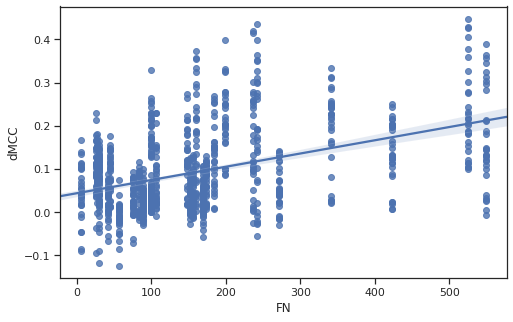

In [24]:
plt.figure(figsize=(8,5))
sns.regplot(x='FN',y='dMCC',data=df,robust=False,order=1);

In [25]:
for col in df:
    if col=='dMCC': continue
    print(col)
    print(pg.corr(df[col],df['dMCC'],method='percbend'),'\n\n') #shepherd , percbend

noise
            n      r         CI95%     r2  adj_r2         p-val  power
percbend  960  0.386  [0.33, 0.44]  0.149   0.147  1.839846e-35    1.0 


FP
            n      r           CI95%    r2  adj_r2         p-val  power
percbend  960 -0.388  [-0.44, -0.33]  0.15   0.149  8.795856e-36    1.0 


FN
            n      r         CI95%     r2  adj_r2         p-val  power
percbend  960  0.366  [0.31, 0.42]  0.134   0.132  7.386201e-32    1.0 


TP
            n      r           CI95%     r2  adj_r2     p-val  power
percbend  960 -0.068  [-0.13, -0.01]  0.005   0.003  0.034395  0.562 


TN
            n      r          CI95%     r2  adj_r2         p-val  power
percbend  960 -0.262  [-0.32, -0.2]  0.069   0.067  1.656270e-16    1.0 


nIR
            n      r         CI95%     r2  adj_r2     p-val  power
percbend  960  0.078  [0.02, 0.14]  0.006   0.004  0.015077  0.682 


IR
            n      r           CI95%     r2  adj_r2         p-val  power
percbend  960 -0.458  [-0.51, -0.41]  0.

In [21]:
pg.corr(df['TN']+df['FN']+df['TP']+df['FP'],df['dMCC'],method='percbend')

,n,r,CI95%,r2,adj_r2,p-val,power
percbend,960,-0.206,"[-0.27, -0.14]",0.043,0.041,1.123292e-10,1.0


### Observations from Per bend Corr Analysis
+ nIR have no relationship with performance loss, so while big IR is bad for performance for clean, it doesn't compound noise problem
+ As overall noise & FN goes higher, p. loss also goes high. Weirdly, as FP gets high, loss goes down. (FN more harmful than FP)
+ As expected, as TN and TP goes high, performance loss goes down. Unexpectedly, effect is small for TP.
+ High Rec is good, but high PR leads to greater loss. Maybe cause PR has high corr with FN
+ Big datasets have low loss

In [ ]:
df['IR_disc'] = df['nIR'] < df['nIR'].median()

In [ ]:
sns.lmplot(x='TP',y='MCC',col='IR_disc',data=df,robust=False,order=1);

In [ ]:
a = list(range(100))
a[::5]